### Knowledge Distillation

Epoch 1: Train Loss: 2.9748, Val Loss: 0.5631, Val Accuracy: 78.05555555555556%
Epoch 2: Train Loss: 0.2289, Val Loss: 0.2210, Val Accuracy: 91.5079365079365%
Epoch 3: Train Loss: 0.1302, Val Loss: 0.1791, Val Accuracy: 94.4047619047619%
Epoch 4: Train Loss: 0.0807, Val Loss: 0.2250, Val Accuracy: 93.01587301587301%
Epoch 5: Train Loss: 0.0616, Val Loss: 0.1864, Val Accuracy: 94.92063492063492%
Epoch 6: Train Loss: 0.0506, Val Loss: 0.1409, Val Accuracy: 96.58730158730158%
Epoch 7: Train Loss: 0.0435, Val Loss: 0.1350, Val Accuracy: 96.5079365079365%
Epoch 8: Train Loss: 0.0417, Val Loss: 0.1394, Val Accuracy: 96.36904761904762%
Epoch 9: Train Loss: 0.0347, Val Loss: 0.1614, Val Accuracy: 96.28968253968254%
Epoch 10: Train Loss: 0.0340, Val Loss: 0.1904, Val Accuracy: 95.11904761904762%


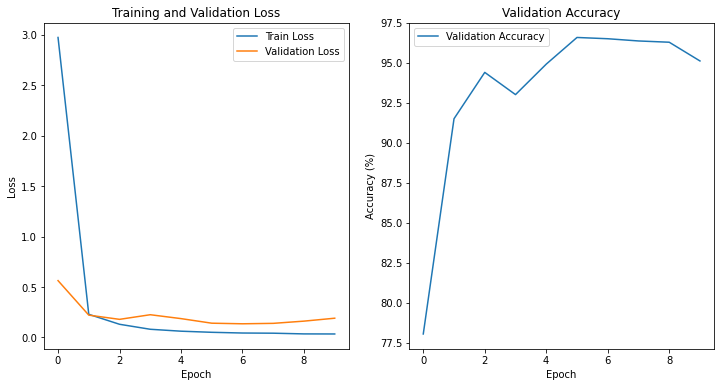

In [10]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models 
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from transformers import BeitForImageClassification, BeitConfig
import seaborn as sns
import os

class FoldDataset(Dataset):
    def __init__(self, root_dir, section, transform=None):
        self.root_dir = root_dir
        self.section = section
        self.transform = transform
        self.samples = []
        for fold in os.listdir(self.root_dir):
            section_path = os.path.join(self.root_dir, fold, self.section)
            for label in ['normal', 'abnormal']:
                label_path = os.path.join(section_path, label)
                if os.path.exists(label_path):
                    for img in os.listdir(label_path):
                        self.samples.append((os.path.join(label_path, img), 0 if label == 'normal' else 1))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

base_dir = '../data'
train_dataset = FoldDataset(root_dir=base_dir, section='train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = FoldDataset(root_dir=base_dir, section='val', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

teacher_model = BeitForImageClassification.from_pretrained('microsoft/beit-base-patch16-224')
teacher_model.load_state_dict(torch.load('../trained_beit_model.pth'))
teacher_model.eval()
teacher_model.cuda()

student_model = models.mobilenet_v3_small(pretrained=True)
student_model.classifier[3] = nn.Linear(student_model.classifier[3].in_features, 1000)
student_model.cuda()

optimizer = torch.optim.AdamW(student_model.parameters(), lr=5e-5)

def mkd_loss(student_logits, teacher_logits, labels, T=2.0, alpha=0.5):
    soft_labels = torch.softmax(teacher_logits / T, dim=1)
    student_log_probs = torch.log_softmax(student_logits / T, dim=1)
    kl_div = nn.KLDivLoss(reduction='batchmean')(student_log_probs, soft_labels) * (T**2)
    ce_loss = nn.CrossEntropyLoss()(student_logits, labels)
    return alpha * ce_loss + (1 - alpha) * kl_div

# Training loop
def train_one_epoch(student_model, teacher_model, data_loader, optimizer, device='cuda'):
    student_model.train()
    total_loss = 0
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        student_outputs = student_model(images)
        with torch.no_grad():
            teacher_outputs = teacher_model(images).logits
        
        loss = mkd_loss(student_outputs, teacher_outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(data_loader)

def validate(model, data_loader, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    average_loss = total_loss / len(data_loader)
    return average_loss, accuracy

num_epochs = 10  # Define number of epochs
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(num_epochs):
    train_loss = train_one_epoch(student_model, teacher_model, train_loader, optimizer, 'cuda')
    val_loss, val_accuracy = validate(student_model, val_loader, 'cuda')
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy}%')

# Plotting the training and validation losses and accuracies
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()


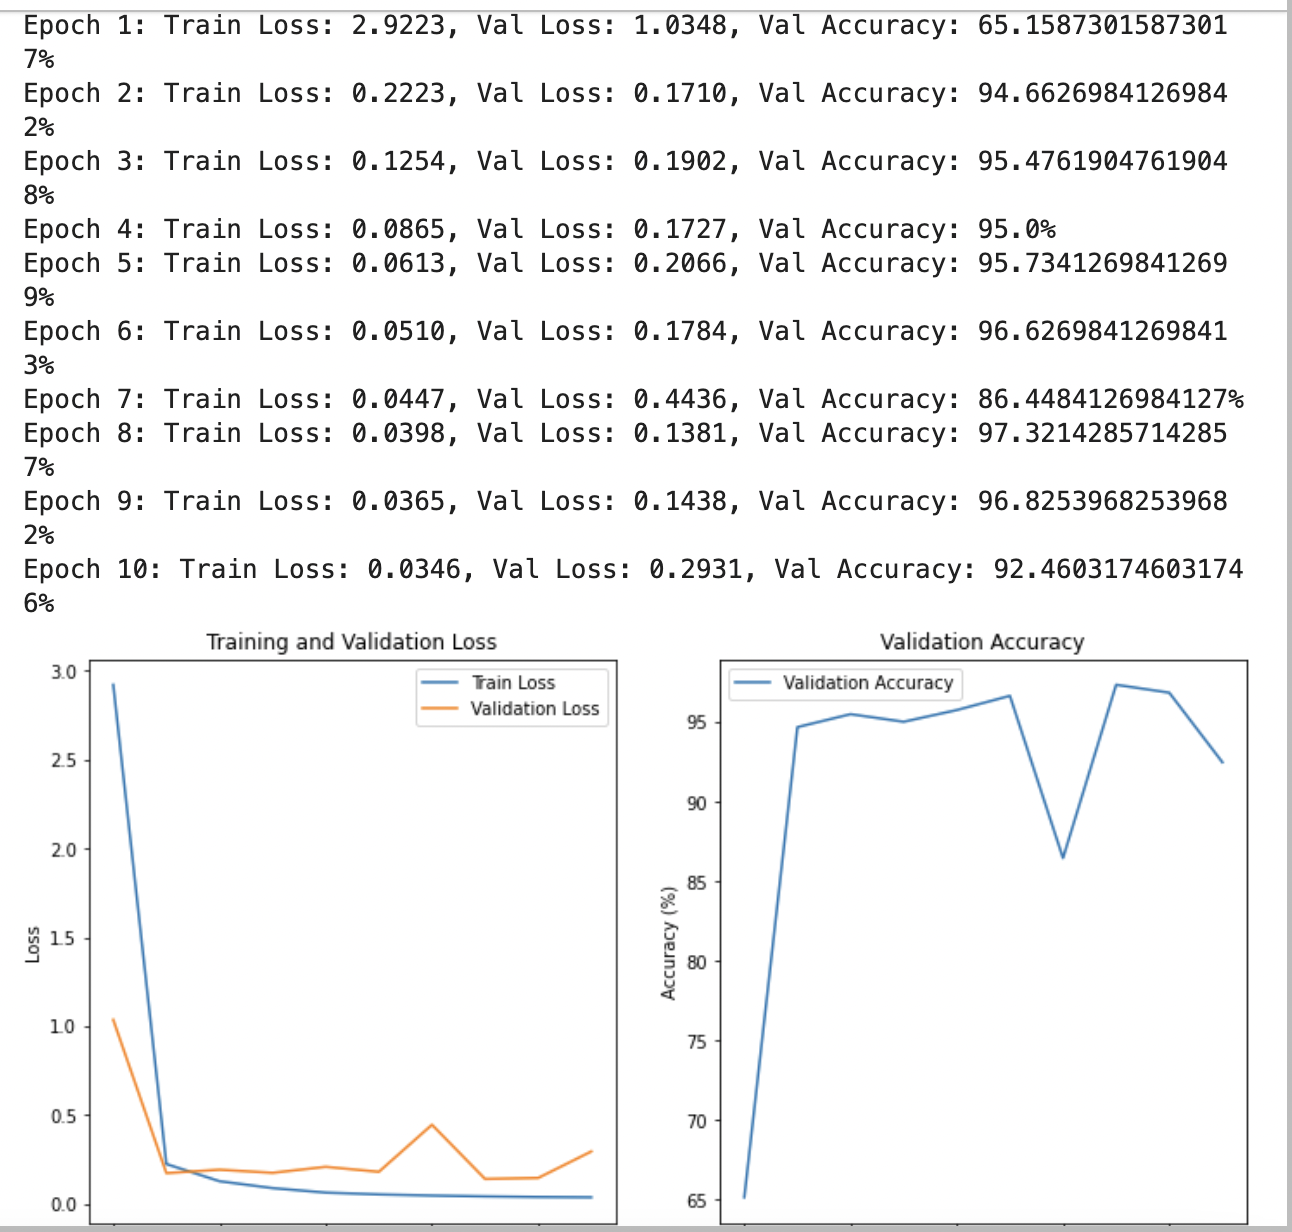

In [2]:
torch.save(student_model.state_dict(), '../student_model_weights.pth')

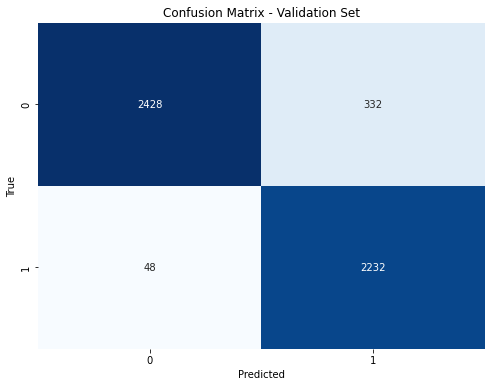

In [9]:
model = models.mobilenet_v3_small(pretrained=True)
model.classifier[3] = nn.Linear(student_model.classifier[3].in_features, 1000)
model_path = '../student_model_weights.pth'
device = torch.device("cuda")
model.load_state_dict(torch.load(model_path))
model.to(device)

def evaluate(model, data_loader, device):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    return y_true, y_pred

# Evaluate the model on the validation set
y_true_val, y_pred_val = evaluate(model, val_loader, device)
# Confusion Matrix
conf_matrix = confusion_matrix(y_true_val, y_pred_val)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Validation Set')
plt.show()